Checking for archives to unpack in 'cubemaps'...
Unpacking 'Standard-Cube-Map(13).zip' to 'cubemaps/13'...
Unpacking 'Standard-Cube-Map(16).zip' to 'cubemaps/16'...
Unpacking 'Standard-Cube-Map(20).zip' to 'cubemaps/20'...
Unpacking 'Standard-Cube-Map(21).zip' to 'cubemaps/21'...
Unpacking 'Standard-Cube-Map(15).zip' to 'cubemaps/15'...
Unpacking 'Standard-Cube-Map(22).zip' to 'cubemaps/22'...
Unpacking 'Standard-Cube-Map(18).zip' to 'cubemaps/18'...
Unpacking 'Standard-Cube-Map(19).zip' to 'cubemaps/19'...
Unpacking 'Standard-Cube-Map(14).zip' to 'cubemaps/14'...
Unpacking 'Standard-Cube-Map(17).zip' to 'cubemaps/17'...
Unpacking 'Standard-Cube-Map(23).zip' to 'cubemaps/23'...
Unpacking process finished.
Selected random cubemap: '4'


2025-08-07 18:17:25.974 (  83.114s) [    76E8FF6B1740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/home/dima/miniconda3/envs/aiijcenv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


Showing a PyVista plot with the random cubemap as background.


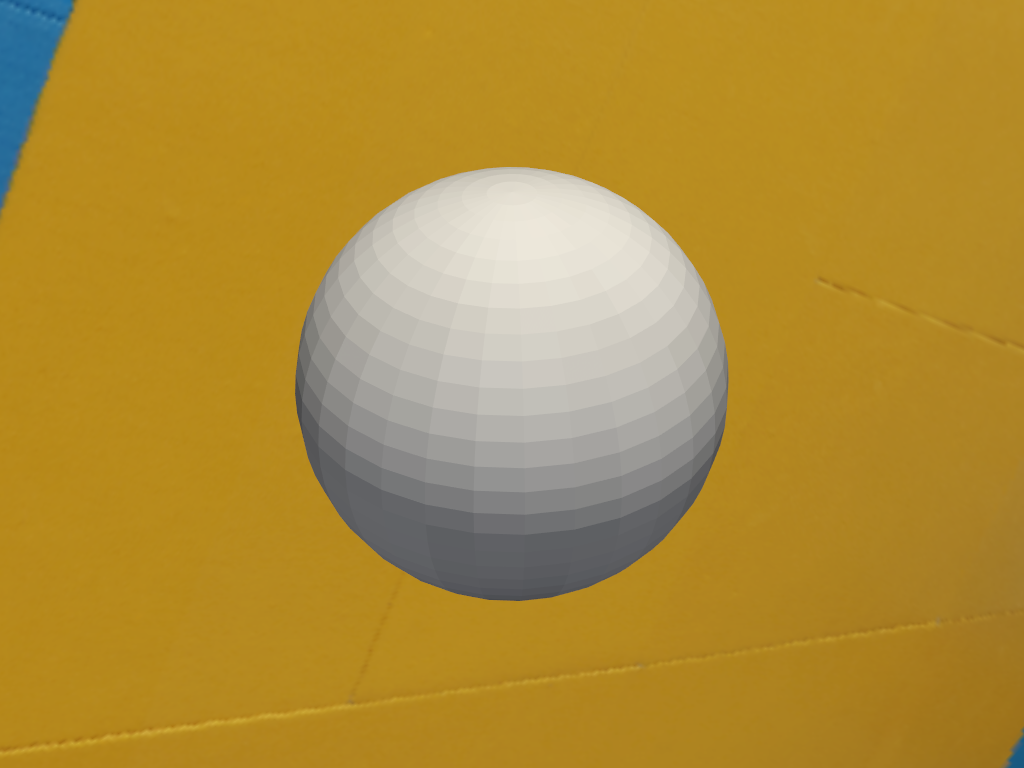

In [2]:
import os
import zipfile
import shutil
import re
import random

# Try to import pyvista, but don't fail if it's not installed.
# The error will be raised only when get_random_pyvista_cubemap is called.
try:
    import pyvista as pv
except ImportError:
    pv = None

def unpack_cubemaps(data_dir='cubemaps'):
    """
    Unpacks .zip archives from a directory into structured subfolders.

    Each archive is unpacked into a subdirectory named after a number 'n'.
    The files inside are renamed according to the pattern: n_[pos/neg][x/y/z].png.
    This function is idempotent, meaning it will not re-unpack archives if the
    target directories already exist.

    Args:
        data_dir (str): The path to the directory containing both the .zip files
                        and where the output folders will be created.
    """
    print(f"Checking for archives to unpack in '{data_dir}'...")

    # Ensure the base directory exists
    if not os.path.exists(data_dir):
        print(f"Directory '{data_dir}' not found. Creating it.")
        os.makedirs(data_dir)

    # --- Main loop to iterate through files in the directory ---
    for filename in os.listdir(data_dir):
        if not filename.endswith('.zip'):
            continue

        # --- Determine the number 'n' from the archive's filename ---
        if filename == 'Standard-Cube-Map.zip':
            n = 0
        else:
            # Use a regular expression to find the number in parentheses, e.g., (1), (12)
            match = re.search(r'\((\d+)\)', filename)
            if match:
                n = int(match.group(1))
            else:
                continue # Skip .zip files that don't match the expected naming pattern

        # --- Create the target directory for the current cubemap ---
        new_dir_path = os.path.join(data_dir, str(n))
        
        # --- Unpack only if the directory doesn't already exist ---
        if os.path.exists(new_dir_path):
            # print(f"Directory '{new_dir_path}' already exists. Skipping unpack.")
            continue
        
        print(f"Unpacking '{filename}' to '{new_dir_path}'...")
        os.makedirs(new_dir_path)

        # --- Unpack and rename files ---
        zip_path = os.path.join(data_dir, filename)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                original_name = os.path.basename(member)

                # Skip directories or non-PNG files within the archive
                if not original_name or not original_name.endswith('.png'):
                    continue
                
                # Logic to determine the new filename
                prefix_char = original_name[0]  # 'n' or 'p'
                axis_char = original_name[1]    # 'x', 'y', or 'z'
                side = 'neg' if prefix_char == 'n' else 'pos'
                
                # Format the new name: e.g., "2_posx.png"
                new_name = f"{n}_{side}{axis_char}.png"
                target_path = os.path.join(new_dir_path, new_name)

                # Extract the file and save it with the new name
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    shutil.copyfileobj(source, target)
    
    print("Unpacking process finished.")


def get_random_pyvista_cubemap(data_dir='cubemaps'):
    """
    Selects a random cubemap from the data directory and returns it as a PyVista object.

    This function first ensures all cubemaps are unpacked. Then, it randomly
    chooses one of the numbered subdirectories and loads the corresponding
    cubemap textures using pyvista.

    Args:
        data_dir (str): The directory containing the numbered cubemap folders.

    Returns:
        pyvista.Texture: A PyVista cubemap texture object, or None if no
                         cubemaps are found or PyVista is not installed.
    """
    if pv is None:
        print("Error: PyVista library is not installed. Please install it with 'pip install pyvista'")
        return None

    # Step 1: Ensure all archives are unpacked into their respective folders.
    unpack_cubemaps(data_dir)

    # Step 2: Find all valid, numbered cubemap directories.
    try:
        subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d.isdigit()]
    except FileNotFoundError:
        print(f"Error: Data directory '{data_dir}' not found.")
        return None

    if not subdirs:
        print(f"Error: No numbered cubemap directories found in '{data_dir}'.")
        return None

    # Step 3: Choose a random cubemap directory.
    random_n = random.choice(subdirs)
    print(f"Selected random cubemap: '{random_n}'")

    # Step 4: Define the parameters for PyVista.
    # The path to the directory containing the 6 images.
    cubemap_path = os.path.join(data_dir, random_n)
    # The prefix for the image files, e.g., "2_". PyVista will append "posx", "negy", etc.
    cubemap_prefix = f"{random_n}_"
    # The file extension.
    cubemap_ext = ".png"

    # Step 5: Create and return the PyVista cubemap object.
    return pv.cubemap(cubemap_path, cubemap_prefix, cubemap_ext)

# --- Example Usage ---
if __name__ == '__main__':
    # Define the directory where your 'Standard-Cube-Map.zip', 'Cube-Map(1).zip', etc. are located.
    CUBEMAPS_DIRECTORY = 'cubemaps'

    # Get a random cubemap.
    random_cubemap = get_random_pyvista_cubemap(CUBEMAPS_DIRECTORY)

    if random_cubemap:
        # If the cubemap was loaded successfully, you can use it in a PyVista plot.
        # For example, let's create a sphere and add the cubemap as a background.
        
        # Ensure PyVista is installed for this part to run
        if pv:
            # Create a plotter
            plotter = pv.Plotter()
            
            # Add a reflective sphere to the scene to showcase the cubemap
            sphere = pv.Sphere()
            plotter.add_mesh(sphere, color='white', metallic=1.0, roughness=0.1)
            
            # Add the cubemap as a background texture
            plotter.add_actor(random_cubemap.to_skybox())
            plotter.set_environment_texture(random_cubemap) # For reflections
            
            print("Showing a PyVista plot with the random cubemap as background.")
            plotter.show()
        else:
            print("Cannot display plot because PyVista is not installed.")

In [3]:
true_colors = ['#5d4b3b', '#3634af', '#799886', '#53463a', '#22150a', '#543c30', '#212021', '#72a18d', '#53403b', '#55453a', '#5478cc', '#373d5a', '#614439', '#13100a', '#585858', '#0a0604', '#4f87b0', '#3b6176', '#335746', '#577eae', '#3b412a', '#243551', '#6c6333', '#6c6964', '#322e2a', '#0b0b0b', '#624941', '#554e48', '#534a57', '#704636', '#1a0e09', '#513e27', '#513928', '#734e52', '#464e57', '#6c5c4a', '#58a5d2', '#6c4e3a', '#776831', '#66e9f8', '#76726c', '#54548b', '#38375f', '#404140', '#3d3933', '#76594c', '#3a3832', '#6a892c', '#353836', '#616261', '#060708', '#756c56', '#788f75', '#312c2e', '#5b9d84', '#616569', '#725d4f', '#413839', '#789888', '#7a763c', '#484848', '#4e4b49', '#41758f', '#5c5d60']

In [5]:
import pyvista as pv
import numpy as np
import os
import random
import math

class STLRenderer:
    """
    A class to render STL files using a flexible configuration for randomization.
    """
    def __init__(self, config: dict):
        """
        Initializes the renderer with a configuration dictionary.
        """
        self.config = config
        self.cubemap_loaders = [get_random_pyvista_cubemap] # Using the helper function
        print(f"Renderer initialized. Found {len(self.cubemap_loaders)} cubemap options.")

    def generate_render(self, stl_path: str, output_path: str, resolution: tuple[int, int],
                        camera_position: list, mesh: pv.PolyData,
                        background_color: str | list | None,
                        cubemap_texture: pv.Texture | None,
                        object_color: str,
                        object_texture: pv.Texture | None,
                        metallic: float,
                        roughness: float):
        """
        Generates a single render with fully specified appearance.
        """
        plotter = pv.Plotter(off_screen=True, window_size=resolution)
        # PBR is crucial for metallic/roughness and realistic textures to work.

        # Apply a projection to the mesh to correctly map the texture
        mesh.texture_map_to_plane(inplace=True)
        
        plotter.add_mesh(
            mesh,
            color=object_color,
            texture=object_texture,
            smooth_shading=True,
            metallic=metallic,
            roughness=roughness,
        )

        if cubemap_texture:
            plotter.add_actor(cubemap_texture.to_skybox())
            plotter.set_environment_texture(cubemap_texture)
        else:
            plotter.set_background(background_color)

        plotter.camera_position = camera_position
        plotter.screenshot(output_path, transparent_background=(background_color is None and not cubemap_texture))
        plotter.close()

    def generate_random_renders(self, stl_path: str, num_renders: int, resolution: tuple[int, int]):
        """
        Orchestrates generating multiple random renders using parameters from the config.
        """
        if not os.path.exists(stl_path):
            print(f"Error: STL file not found at {stl_path}")
            return

        mesh = pv.read(stl_path)
        mesh.translate(-np.array(mesh.center), inplace=True)

        textures_dir = self.config['textures_dir']
        texture_files = []
        if textures_dir and os.path.exists(textures_dir):
            texture_files = [os.path.join(textures_dir, f) for f in os.listdir(textures_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        output_dir = self.config['output_dir']
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(stl_path))[0]
        
        print(f"\nGenerating {num_renders} random renders for {base_name}.stl...")
        print(f"Model diagonal length: {mesh.length:.2f}. Camera distance will be adapted.")
        if texture_files: print(f"Found {len(texture_files)} textures.")

        for i in range(num_renders):
            # --- 1. Randomize Object Appearance ---
            use_texture = random.choice([True, False]) and texture_files
            obj_color, obj_texture = 'white', None
            
            if use_texture:
                texture_path = random.choice(texture_files)
                obj_texture = pv.read_texture(texture_path)
                appearance_log = f"Texture: {os.path.basename(texture_path)}"
            else:
                obj_color = random.choice(self.config['object_colors'])
                appearance_log = f"Color: {obj_color}"

            # Randomize PBR material properties
            metallic = random.uniform(*self.config['pbr_metallic_range'])
            roughness = random.uniform(*self.config['pbr_roughness_range'])
            appearance_log += f", M={metallic:.2f}, R={roughness:.2f}"

            # --- 2. Randomize Background ---
            use_cubemap = random.choice([True, False]) and self.cubemap_loaders
            bg_color, cubemap, bg_log = None, None, ""

            if use_cubemap:
                cubemap = get_random_pyvista_cubemap()
                bg_log = f"Cubemap"
            else:
                bg_color = random.choice(self.config['background_options'])
                bg_log = "transparent" if bg_color is None else str(bg_color)
            
            # --- 3. Set Camera Position from the upper hemisphere ---
            camera_pos = get_random_camera_position(mesh, self.config)
            
            # --- 4. Generate and Save ---
            output_filename = os.path.join(output_dir, f"{base_name}_{i + 1}.png")
            self.generate_render(
                stl_path=stl_path,
                output_path=output_filename,
                resolution=resolution,
                camera_position=camera_pos,
                mesh=mesh, # No need to copy, plotter is re-created each time
                background_color=bg_color,
                cubemap_texture=cubemap,
                object_color=obj_color,
                object_texture=obj_texture,
                metallic=metallic,
                roughness=roughness
            )
            print(f"  -> Saved {output_filename} (Object: {appearance_log} | BG: {bg_log})")

def get_random_camera_position(mesh: pv.PolyData, config: dict) -> list:
    """Generates a random camera position adapted to the mesh's size and config constraints."""
    model_size = mesh.length
    distance = random.uniform(*config['camera_distance_range']) * model_size
    if distance < 1.0: distance = 1.0

    # Constrain camera to the upper hemisphere by limiting elevation
    azimuth = random.uniform(0, 360)
    elevation = random.uniform(*config['camera_elevation_range'])

    elev_rad, azim_rad = math.radians(90 - elevation), math.radians(azimuth)
    x = distance * math.sin(elev_rad) * math.cos(azim_rad)
    y = distance * math.sin(elev_rad) * math.sin(azim_rad)
    z = distance * math.cos(elev_rad)

    return [(x, y, z), [0, 0, 0], [0, 0, 1]] # View-up is always Z axis

if __name__ == "__main__":
    # --- Single Configuration Object ---
    RENDER_CONFIG = {
        "output_dir": "renders",
        "textures_dir": "textures",
        "object_colors": true_colors,
        "background_options": ["black", "grey", "#303030", None],
        
        # PBR material properties randomization
        "pbr_metallic_range": (0.0, 0.9),  # 0.0=non-metal, 1.0=full metal
        "pbr_roughness_range": (0.1, 0.9), # 0.0=polished, 1.0=matte/diffuse
        
        # Camera randomization
        "camera_distance_range": (2.5, 4.5), # Relative to model size
        "camera_elevation_range": (10, 80),  # Degrees. 90=top-down, 0=horizon
    }

    # --- Runtime Parameters ---
    STL_FILE = "sample_cube.stl"
    NUM_RENDERS = 10
    RESOLUTION = (512, 512)

    # --- Setup and Execution ---
    if not os.path.exists(STL_FILE):
        pv.Cube().save(STL_FILE)
        print(f"Created a sample file: {STL_FILE}")
    
    if not os.path.exists(RENDER_CONFIG['textures_dir']):
        os.makedirs(RENDER_CONFIG['textures_dir'])
        print(f"Created directory: {RENDER_CONFIG['textures_dir']}")
        print(f"!!! PLEASE ADD YOUR .JPG/.PNG TEXTURE FILES TO THIS DIRECTORY !!!")

    renderer = STLRenderer(config=RENDER_CONFIG)
    renderer.generate_random_renders(
        stl_path=STL_FILE,
        num_renders=NUM_RENDERS,
        resolution=RESOLUTION,
    )
    print(f"\nSuccess! All renders saved in '{RENDER_CONFIG['output_dir']}'.")

Renderer initialized. Found 1 cubemap options.

Generating 10 random renders for sample_cube.stl...
Model diagonal length: 1.73. Camera distance will be adapted.
Found 13 textures.
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '2'
  -> Saved renders/sample_cube_1.png (Object: Color: #484848, M=0.12, R=0.85 | BG: Cubemap)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '19'
  -> Saved renders/sample_cube_2.png (Object: Color: #6c4e3a, M=0.23, R=0.58 | BG: Cubemap)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '12'
  -> Saved renders/sample_cube_3.png (Object: Color: #624941, M=0.73, R=0.53 | BG: Cubemap)
Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '0'
  -> Saved renders/sample_cube_4.png (Object: Texture: rusty_metal_03_diff_4k.jpg, M=0.48, R=0.16 | BG: Cubemap)
Chec